In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import os
import csv
from collections import Counter
from scipy.stats import lognorm, expon, norm, kstest, linregress
from sklearn.metrics import r2_score
import numpy as np
import powerlaw as pwl
import pandas as pd

## INITIALIZE DATA

In [2]:
# DATA FOLDERS
DATA = "data"

POLITICIAN_NODES = os.path.join(DATA, "fb-pages-politician.nodes")
POLITICIAN_EDGES = os.path.join(DATA, "fb-pages-politician.edges")

PUBLIC_FIGURES_NODES = os.path.join(DATA, "fb-pages-public-figure.nodes")
PUBLIC_FIGURES_EDGES = os.path.join(DATA, "fb-pages-public-figure.edges")

In [3]:
# CREATING POLITICIAN NETWORK

politician_graph = nx.Graph()

# Read and add nodes
with open(POLITICIAN_NODES, 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        # Unpack the row into its components
        node_id, politician_name, node_index = row
        
        # Add the node with its attributes (id and name)
        politician_graph.add_node(int(node_index), id=node_id, name=politician_name)
        
# Read and add edges
with open(POLITICIAN_EDGES, 'r') as f:
    for line in f:
        # Split the line by commas
        node1, node2 = line.strip().split(',')
        
        # Add the edge between node1 and node2
        politician_graph.add_edge(int(node1), int(node2))

In [4]:
# CREATING PUBLIC FIGURES NETWORK

public_figures_graph = nx.Graph()

# Read and add nodes
with open(PUBLIC_FIGURES_NODES, 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        # Unpack the row into its components
        node_id, politician_name, node_index = row
        
        # Add the node with its attributes (id and name)
        public_figures_graph.add_node(int(node_index), id=node_id, name=politician_name)
        
# Read and add edges
with open(PUBLIC_FIGURES_EDGES, 'r') as f:
    for line in f:
        # Split the line by commas
        node1, node2 = line.strip().split(',')
        
        # Add the edge between node1 and node2
        public_figures_graph.add_edge(int(node1), int(node2))

## FUNCTIONS FOR CENTRALITY ANALYSIS

In [5]:
# CENTRALITY ANALYSIS FUNCTIONS

sns.set_theme(context='paper', style="ticks", font='serif', font_scale=1.3)

def plot_histogram(politician_metric_dict, public_metric_dict, metric):
    plt.figure(figsize=(10, 6))

    plt.hist(politician_metric_dict.values(), bins=30, color='skyblue', edgecolor='black', alpha=0.7, density=False, label='Politicians')
    plt.hist(public_metric_dict.values(), bins=30, color='red', edgecolor='black', alpha=0.3, density=False, label='Public Figures')

    # Adding title, labels, and legend
    plt.title(f'Normalized {metric} Centrality Distribution', fontsize=18)
    plt.xlabel(f'{metric} Centrality', fontsize=16)
    plt.ylabel('Frequency', fontsize=16)
    plt.legend()

    plt.show()

    return None

def get_metric_stats(metric_dict, graph):
    # Max degree node
    max_node = max(metric_dict, key=metric_dict.get)
    max_degree = metric_dict[max_node]
    
    # Min degree node
    min_node = min(metric_dict, key=metric_dict.get)
    min_degree = metric_dict[min_node]
    
    # Average degree value
    avg_degree = np.mean(list(metric_dict.values()))
    
    return {
        'max_node': graph.nodes[max_node]['name'],
        'max_value': max_degree,
        'min_node': graph.nodes[min_node]['name'],
        'min_value': min_degree,
        'avg_value': avg_degree
    }


def get_frequencies(metric):
    counts = Counter(metric)
    x = np.array(list(counts.keys()))
    y = np.array(list(counts.values())) / len(metric)  # Normalize frequencies
    return x, y


# Calculate R^2
def calculate_r_squared(observed, predicted):
    if len(observed) != len(predicted):
        raise ValueError("The length of observed and predicted arrays must be the same.")
    return r2_score(observed, predicted)


# Log-likelihood function for different distributions
def log_likelihood(distribution, params, data, fit):
    if distribution == 'power_law':
        alpha = fit.power_law.alpha
        xmin = fit.power_law.xmin
        # Compute log-likelihood for the power-law distribution
        likelihood = np.sum(np.log(data[data >= xmin] ** (-alpha) / np.sum(data[data >= xmin] ** (-alpha))))
        return likelihood
    elif distribution == 'lognormal':
        mu, sigma = params
        return np.sum(norm.logpdf(np.log(data), mu, sigma))
    elif distribution == 'exponential':
        lambd = params
        return np.sum(expon.logpdf(data, scale=1/lambd))


# Calculate the fit statistics for a given graph's degree distribution
def calculate_fit_statistics(degree_list):
    fit_function = pwl.Fit(degree_list)
    
    x, y = get_frequencies([x for x in degree_list if x > fit_function.power_law.xmin])
    
    # Predicted values for each fit type
    y_pred_powerlaw = np.array([fit_function.power_law.pdf(x_val) for x_val in x])
    y_pred_lognormal = np.array([fit_function.lognormal.pdf(x_val) for x_val in x])
    y_pred_exponential = np.array([fit_function.exponential.pdf(x_val) for x_val in x])
    
    # R^2 for each fit type
    R2_powerlaw = calculate_r_squared(y, y_pred_powerlaw)
    R2_lognormal = calculate_r_squared(y, y_pred_lognormal)
    R2_exponential = calculate_r_squared(y, y_pred_exponential)
    
    # K-S test value for each fit type
    K_S_powerlaw = fit_function.power_law.D
    K_S_lognormal = fit_function.lognormal.D
    K_S_exponential = fit_function.exponential.D
    
    # MLE for each fit type
    MLE_powerlaw = log_likelihood('power_law', None, np.array(degree_list), fit_function)
    MLE_lognormal = log_likelihood('lognormal', (fit_function.lognormal.mu, fit_function.lognormal.sigma), np.array(degree_list), fit_function)
    MLE_exponential = log_likelihood('exponential', fit_function.exponential.Lambda, np.array(degree_list), fit_function)
    
    return {
        'R2': [R2_powerlaw, R2_lognormal, R2_exponential],
        'K-S': [K_S_powerlaw, K_S_lognormal, K_S_exponential],
        'MLE': [MLE_powerlaw, MLE_lognormal, MLE_exponential]
    }


## DEGREE CENTRALITY

In [6]:
# DEGREE CENTRALITY COMPUTATION

politician_degree = nx.degree_centrality(politician_graph)
public_figures_degree = nx.degree_centrality(public_figures_graph)

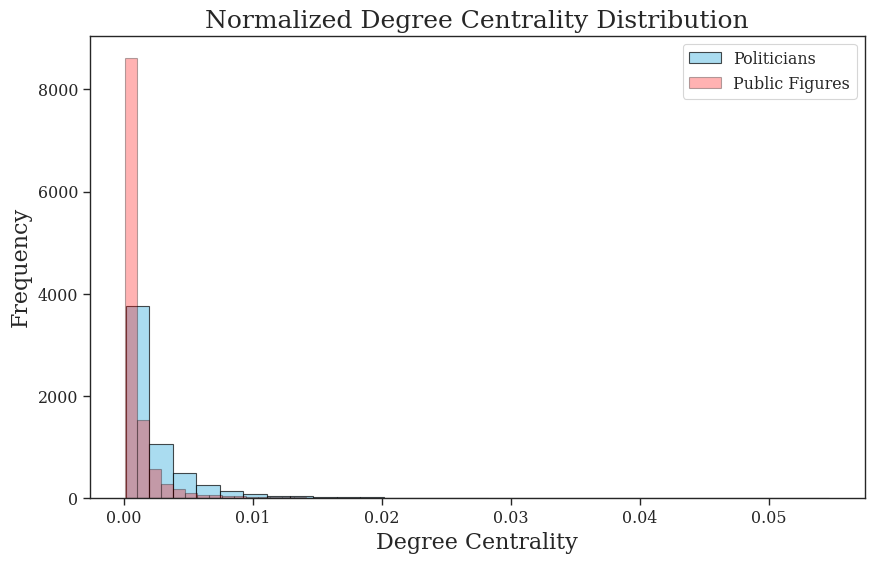

\begin{tabular}{lll}
\toprule
 & Politicians & Public Figures \\
\midrule
Max Degree Node & Manfred Weber (0.0547) & Oprah Winfrey (0.0282) \\
Min Degree Node & Chris White (0.0002) & Rosana Franco (0.0001) \\
Average Degree & 0.0024 & 0.0010 \\
\bottomrule
\end{tabular}



In [7]:
# DEGREE CENTRALITY ANALYSIS 


plot_histogram(politician_degree, public_figures_degree, "Degree")

# Get degree stats for politicians and public figures
politician_stats = get_metric_stats(politician_degree, politician_graph)
public_figures_stats = get_metric_stats(public_figures_degree, public_figures_graph)

# Create a DataFrame to display in a table format
comparison_df = pd.DataFrame({
    "": ["Max Degree Node", "Min Degree Node", "Average Degree"],
    "Politicians": [
        f"{politician_stats['max_node']} ({politician_stats['max_value']:.4f})",
        f"{politician_stats['min_node']} ({politician_stats['min_value']:.4f})",
        f"{politician_stats['avg_value']:.4f}"
    ],
    "Public Figures": [
        f"{public_figures_stats['max_node']} ({public_figures_stats['max_value']:.4f})",
        f"{public_figures_stats['min_node']} ({public_figures_stats['min_value']:.4f})",
        f"{public_figures_stats['avg_value']:.4f}"
    ]
})

# Print the LaTeX code for the table
print(comparison_df.to_latex(index=False))


Calculating best minimal value for power law fit


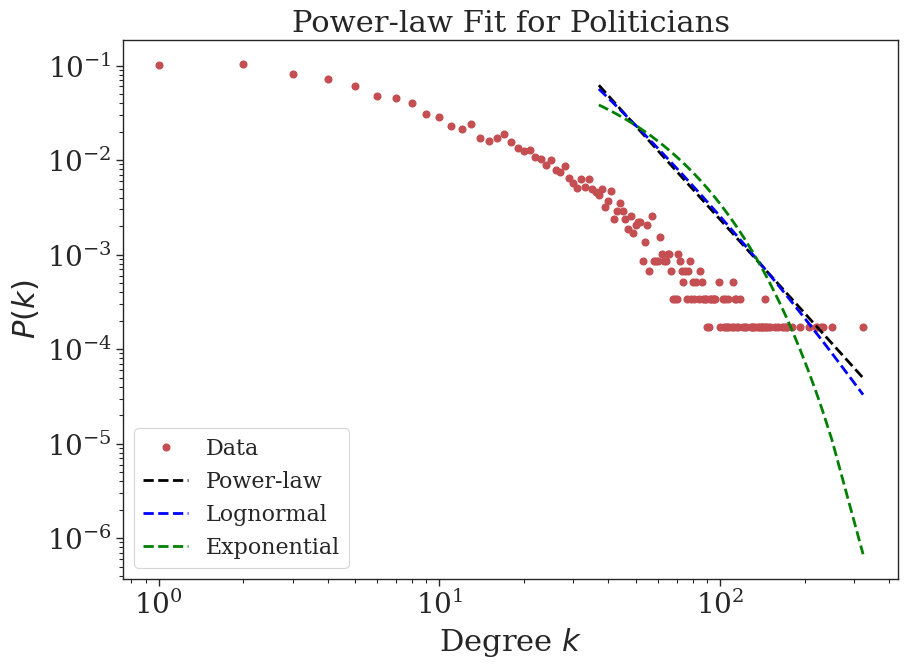

K-S Test LaTeX Table:
\begin{tabular}{llr}
\toprule
Distribution & Fit Parameters & K-S Statistic \\
\midrule
Power-law & alpha = 3.2908, x_min = 37.0 & 0.0296 \\
Lognormal & mu = 0.1474, sigma = 1.3659, x_min = 37.0 & 0.0213 \\
Exponential & Lambda = 0.0383, x_min = 37.0 & 0.0848 \\
\bottomrule
\end{tabular}



In [10]:
# FIT PLOTTING FOR POLITICIANS

# Politician degree analysis (distribution, powerlaw, lognormal and exponential)
deg_politicians = dict(politician_graph.degree()).values()
deg_distri_politicians = Counter(deg_politicians)

x_politicians = []
y_politicians = []
for i in sorted(deg_distri_politicians):   
    x_politicians.append(i)
    y_politicians.append(deg_distri_politicians[i] / len(politician_graph))

degree_politicians = list(deg_politicians)
fit_function_politicians = pwl.Fit(degree_politicians)

# Retrieve the fit parameters and format them
powerlaw_params = f"alpha = {fit_function_politicians.power_law.alpha:.4f}, x_min = {fit_function_politicians.power_law.xmin}"
lognormal_params = f"mu = {fit_function_politicians.lognormal.mu:.4f}, sigma = {fit_function_politicians.lognormal.sigma:.4f}, x_min = {fit_function_politicians.lognormal.xmin}"
exponential_params = f"Lambda = {fit_function_politicians.exponential.Lambda:.4f}, x_min = {fit_function_politicians.exponential.xmin}"

# Create the figure and axes objects
fig, ax = plt.subplots(figsize=(10, 7))

# Plot the normalized frequency of politician degrees
ax.plot(x_politicians, y_politicians, 'ro', label='Data')

# Plot the fitted PDFs for power-law, lognormal, and exponential distributions on the same axes
fit_function_politicians.power_law.plot_pdf(ax=ax, color='black', linestyle='--', linewidth=2, label='Power-law')
fit_function_politicians.lognormal.plot_pdf(ax=ax, color='blue', linestyle='--', linewidth=2, label='Lognormal')
fit_function_politicians.exponential.plot_pdf(ax=ax, color='green', linestyle='--', linewidth=2, label='Exponential')

# Customize the plot
ax.legend(fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlabel('Degree $k$', fontsize=22)
ax.set_ylabel('$P(k)$', fontsize=22)
ax.set_title('Power-law Fit for Politicians', fontsize=22)

plt.show()

# Gather K-S test values
ks_data = {
    "Distribution": ["Power-law", "Lognormal", "Exponential"],
    "Fit Parameters": [powerlaw_params, lognormal_params, exponential_params],
    "K-S Statistic": [fit_function_politicians.power_law.D, fit_function_politicians.lognormal.D, fit_function_politicians.exponential.D]
}

ks_table = pd.DataFrame(ks_data)

# Print K-S test LaTeX table
print("K-S Test LaTeX Table:")
print(ks_table.to_latex(index=False, float_format="%.4f"))


Calculating best minimal value for power law fit


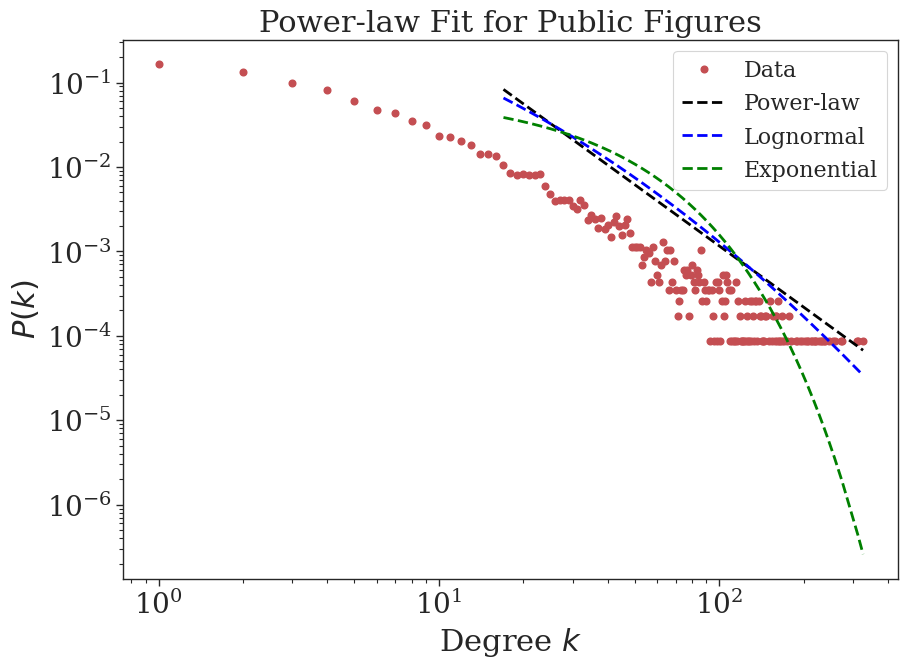

K-S Test LaTeX Table:
\begin{tabular}{llr}
\toprule
Distribution & Fit Parameters & K-S Statistic \\
\midrule
Power-law & alpha = 2.4086, x_min = 17.0 & 0.0564 \\
Lognormal & mu = 1.6272, sigma = 1.3111, x_min = 17.0 & 0.0234 \\
Exponential & Lambda = 0.0385, x_min = 17.0 & 0.1101 \\
\bottomrule
\end{tabular}



In [11]:
#$ FIT PLOTTING FOR PUBLIC FIGURES

deg_public_figures = dict(public_figures_graph.degree()).values()
deg_distri_public_figures = Counter(deg_public_figures)

x_public_figures = []
y_public_figures = []
for i in sorted(deg_distri_public_figures):   
    x_public_figures.append(i)
    y_public_figures.append(deg_distri_public_figures[i] / len(public_figures_graph))

degree_public_figures = list(deg_public_figures)
fit_function_public_figures = pwl.Fit(degree_public_figures)

# Retrieve and format fit parameters
powerlaw_params = f"alpha = {fit_function_public_figures.power_law.alpha:.4f}, x_min = {fit_function_public_figures.power_law.xmin}"
lognormal_params = f"mu = {fit_function_public_figures.lognormal.mu:.4f}, sigma = {fit_function_public_figures.lognormal.sigma:.4f}, x_min = {fit_function_public_figures.lognormal.xmin}"
exponential_params = f"Lambda = {fit_function_public_figures.exponential.Lambda:.4f}, x_min = {fit_function_public_figures.exponential.xmin}"

# Create the figure and axes objects
fig, ax = plt.subplots(figsize=(10, 7))

# Plot the normalized frequency of public figures degrees
ax.plot(x_public_figures, y_public_figures, 'ro', label='Data')

# Plot the fitted PDFs for power-law, lognormal, and exponential distributions on the same axes
fit_function_public_figures.power_law.plot_pdf(ax=ax, color='black', linestyle='--', linewidth=2, label='Power-law')
fit_function_public_figures.lognormal.plot_pdf(ax=ax, color='blue', linestyle='--', linewidth=2, label='Lognormal')
fit_function_public_figures.exponential.plot_pdf(ax=ax, color='green', linestyle='--', linewidth=2, label='Exponential')

# Customize the plot
ax.legend(fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlabel('Degree $k$', fontsize=22)
ax.set_ylabel('$P(k)$', fontsize=22)
ax.set_title('Power-law Fit for Public Figures', fontsize=22)

plt.show()

# Gather K-S test values
ks_data = {
    "Distribution": ["Power-law", "Lognormal", "Exponential"],
    "Fit Parameters": [powerlaw_params, lognormal_params, exponential_params],
    "K-S Statistic": [fit_function_public_figures.power_law.D, fit_function_public_figures.lognormal.D, fit_function_public_figures.exponential.D]
}

ks_table = pd.DataFrame(ks_data)

# Print K-S test LaTeX table
print("K-S Test LaTeX Table:")
print(ks_table.to_latex(index=False, float_format="%.4f"))

# Gather log-likelihood ratio and p-values
#llr_data = {
#    "Comparison": ["Power-law vs Lognormal", "Power-law vs Exponential", "Lognormal vs Exponential"],
#    "Log-Likelihood Ratio": [R1, R2, R3],
#    "p-value": [p1, p2, p3]
#}
#
#llr_table = pd.DataFrame(llr_data)
#
## Print log-likelihood ratio LaTeX table
#print("\nLog-Likelihood Ratio Test LaTeX Table:")
#print(llr_table.to_latex(index=False, float_format="%.7f"))

## CLOSENESS CENTRALITY

In [58]:
# Calculate closeness centrality for each graph
politician_closeness = nx.closeness_centrality(politician_graph)
public_figures_closeness = nx.closeness_centrality(public_figures_graph)

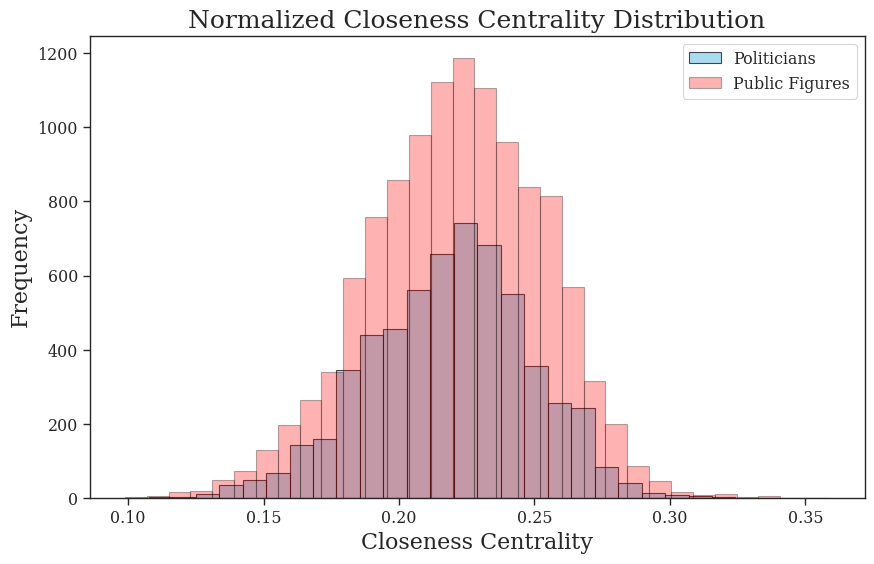

\begin{tabular}{lll}
\toprule
 & Politicians & Public Figures \\
\midrule
Max Closeness Node & Barack Obama (0.3588) & Daniel Amos (0.3407) \\
Min Closeness Node & Chris Sununu (0.0990) & Ismael Del Toro Castro (0.0988) \\
Average Closeness & 0.2187 & 0.2213 \\
\bottomrule
\end{tabular}



In [63]:
# Plot histogram of closeness centrality values
plot_histogram(politician_closeness, public_figures_closeness, "Closeness")

# Get closeness centrality stats for politicians and public figures
politician_stats = get_metric_stats(politician_closeness, politician_graph)
public_figures_stats = get_metric_stats(public_figures_closeness, public_figures_graph)

# Create a DataFrame to display in a table format
comparison_df = pd.DataFrame({
    "": ["Max Closeness Node", "Min Closeness Node", "Average Closeness"],
    "Politicians": [
        f"{politician_stats['max_node']} ({politician_stats['max_value']:.4f})",
        f"{politician_stats['min_node']} ({politician_stats['min_value']:.4f})",
        f"{politician_stats['avg_value']:.4f}"
    ],
    "Public Figures": [
        f"{public_figures_stats['max_node']} ({public_figures_stats['max_value']:.4f})",
        f"{public_figures_stats['min_node']} ({public_figures_stats['min_value']:.4f})",
        f"{public_figures_stats['avg_value']:.4f}"
    ]
})

# Print the LaTeX code for the table
print(comparison_df.to_latex(index=False))

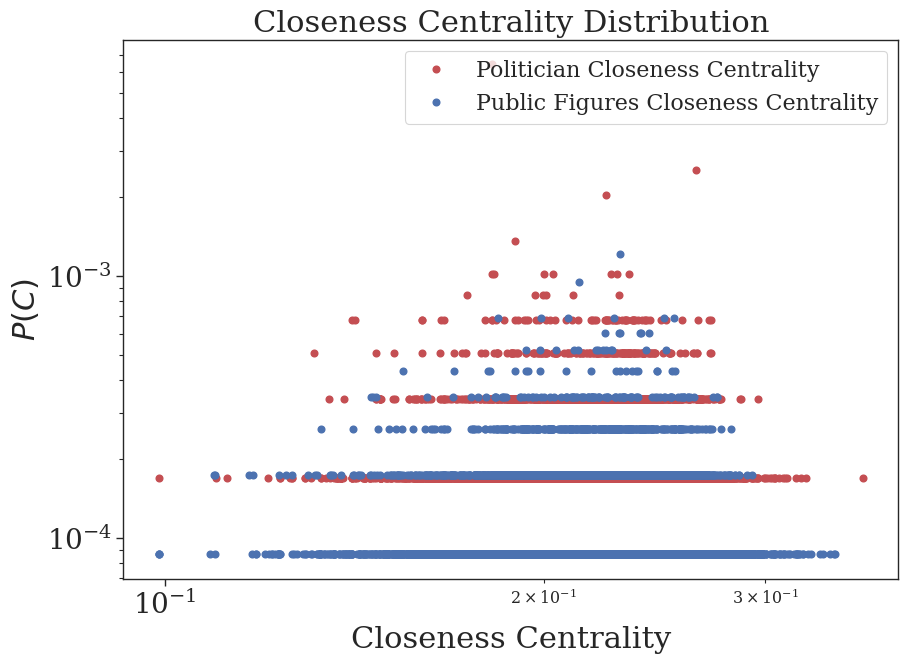

In [64]:
# Set the threshold for filtering
threshold = 0

# Calculate closeness centrality and filter values based on the threshold
closeness_values_politicians = [v for v in politician_closeness.values() if v > threshold]
closeness_values_public = [v for v in public_figures_closeness.values() if v > threshold]

# Ensure there are entries above the threshold before proceeding
if closeness_values_politicians and closeness_values_public:
    # Create a frequency distribution of closeness centrality values
    closeness_distribution_politicians = Counter(closeness_values_politicians)
    closeness_distribution_public = Counter(closeness_values_public)

    # Sort the distributions and prepare data for plotting
    sorted_closeness_politicians = sorted(closeness_distribution_politicians.keys())
    sorted_counts_politicians = [closeness_distribution_politicians[d] for d in sorted_closeness_politicians]
    x_closeness_politician = sorted_closeness_politicians
    y_closeness_politician = [closeness_distribution_politicians[d] / sum(sorted_counts_politicians) for d in sorted_closeness_politicians]

    sorted_closeness_public = sorted(closeness_distribution_public.keys())
    sorted_counts_public = [closeness_distribution_public[d] for d in sorted_closeness_public]
    x_closeness_public = sorted_closeness_public
    y_closeness_public = [closeness_distribution_public[d] / sum(sorted_counts_public) for d in sorted_closeness_public]

    # Create the figure and axes objects
    fig, ax = plt.subplots(figsize=(10, 7))

    # Plot the normalized frequency of closeness centrality
    ax.plot(x_closeness_politician, y_closeness_politician, 'ro', label='Politician Closeness Centrality')
    ax.plot(x_closeness_public, y_closeness_public, 'bo', label='Public Figures Closeness Centrality')

    # Set both axes to log scale
    ax.set_xscale('log')
    ax.set_yscale('log')

    # Customize the plot
    ax.legend(fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_xlabel('Closeness Centrality', fontsize=22)
    ax.set_ylabel('$P(C)$', fontsize=22)
    ax.set_title('Closeness Centrality Distribution', fontsize=22)

    plt.show()
else:
    print("No closeness centrality values are above the threshold for one or both graphs.")

## BETWEENNESS

In [48]:
politician_betweenness = nx.betweenness_centrality(politician_graph)
public_figures_betweenness = nx.betweenness_centrality(public_figures_graph)

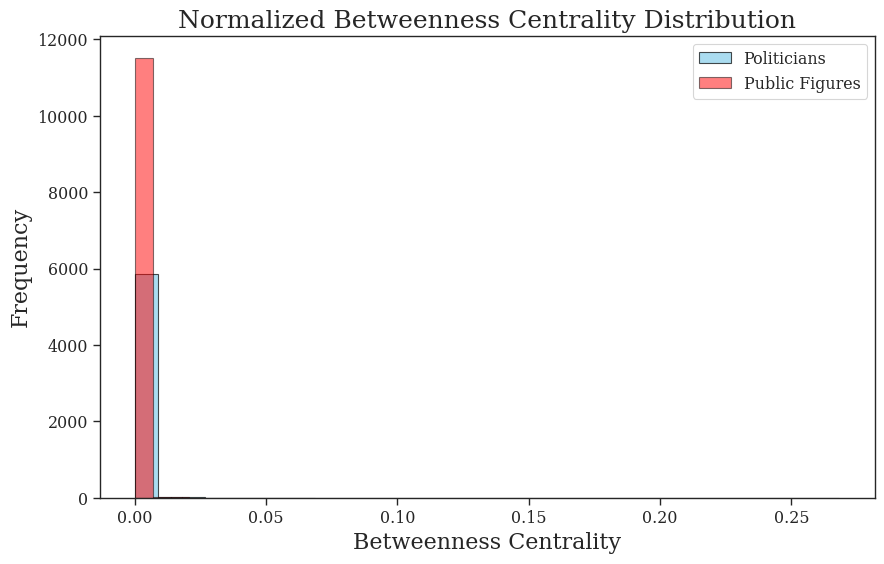

\begin{tabular}{lll}
\toprule
 & Politicians & Public Figures \\
\midrule
Max Betweenness Node & Barack Obama (0.2683) & Daniel Amos (0.0687) \\
Min Betweenness Node & Chris White (0.0000) & Rosana Franco (0.0000) \\
Average Betweenness & 0.0006 & 0.0003 \\
\bottomrule
\end{tabular}



In [57]:
# Plot histogram of betweenness centrality values
plot_histogram(politician_betweenness, public_figures_betweenness, "Betweenness")

# Get betweenness centrality stats for politicians and public figures
politician_stats = get_metric_stats(politician_betweenness, politician_graph)
public_figures_stats = get_metric_stats(public_figures_betweenness, public_figures_graph)

# Create a DataFrame to display in a table format
comparison_df = pd.DataFrame({
    "": ["Max Betweenness Node", "Min Betweenness Node", "Average Betweenness"],
    "Politicians": [
        f"{politician_stats['max_node']} ({politician_stats['max_value']:.4f})",
        f"{politician_stats['min_node']} ({politician_stats['min_value']:.4f})",
        f"{politician_stats['avg_value']:.4f}"
    ],
    "Public Figures": [
        f"{public_figures_stats['max_node']} ({public_figures_stats['max_value']:.4f})",
        f"{public_figures_stats['min_node']} ({public_figures_stats['min_value']:.4f})",
        f"{public_figures_stats['avg_value']:.4f}"
    ]
})

# Print the LaTeX code for the table
print(comparison_df.to_latex(index=False))

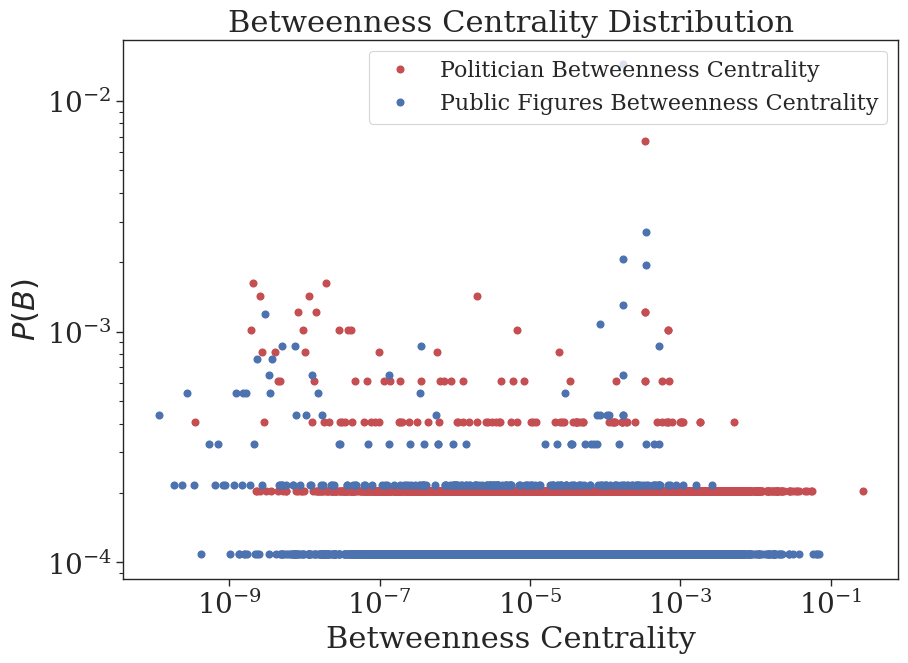

In [52]:
# Set the threshold for filtering
threshold = 0

# Filter values based on the threshold
betweenness_values_politicians = [v for v in politician_betweenness.values() if v > threshold]
betweenness_values_public = [v for v in public_figures_betweenness.values() if v > threshold]

# Ensure there are entries above the threshold before proceeding
if betweenness_values_politicians and betweenness_values_public:
    # Create a frequency distribution of betweenness centrality values
    betweenness_distribution_politicians = Counter(betweenness_values_politicians)
    betweenness_distribution_public = Counter(betweenness_values_public)

    # Sort the distributions and prepare data for plotting
    sorted_betweenness_politicians = sorted(betweenness_distribution_politicians.keys())
    sorted_counts_politicians = [betweenness_distribution_politicians[d] for d in sorted_betweenness_politicians]
    x_betweenness_politician = sorted_betweenness_politicians
    y_betweenness_politician = [betweenness_distribution_politicians[d] / sum(sorted_counts_politicians) for d in sorted_betweenness_politicians]

    sorted_betweenness_public = sorted(betweenness_distribution_public.keys())
    sorted_counts_public = [betweenness_distribution_public[d] for d in sorted_betweenness_public]
    x_betweenness_public = sorted_betweenness_public
    y_betweenness_public = [betweenness_distribution_public[d] / sum(sorted_counts_public) for d in sorted_betweenness_public]

    # Create the figure and axes objects
    fig, ax = plt.subplots(figsize=(10, 7))

    # Plot the normalized frequency of betweenness centrality
    ax.plot(x_betweenness_politician, y_betweenness_politician, 'ro', label='Politician Betweenness Centrality')
    ax.plot(x_betweenness_public, y_betweenness_public, 'bo', label='Public Figures Betweenness Centrality')

    # Set both axes to log scale
    ax.set_xscale('log')
    ax.set_yscale('log')

    # Customize the plot
    ax.legend(fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_xlabel('Betweenness Centrality', fontsize=22)
    ax.set_ylabel('$P(B)$', fontsize=22)
    ax.set_title('Betweenness Centrality Distribution', fontsize=22)

    plt.show()
else:
    print("No betweenness centrality values are above the threshold for one or both graphs.")

## EIGENVECTOR CENTRALITY

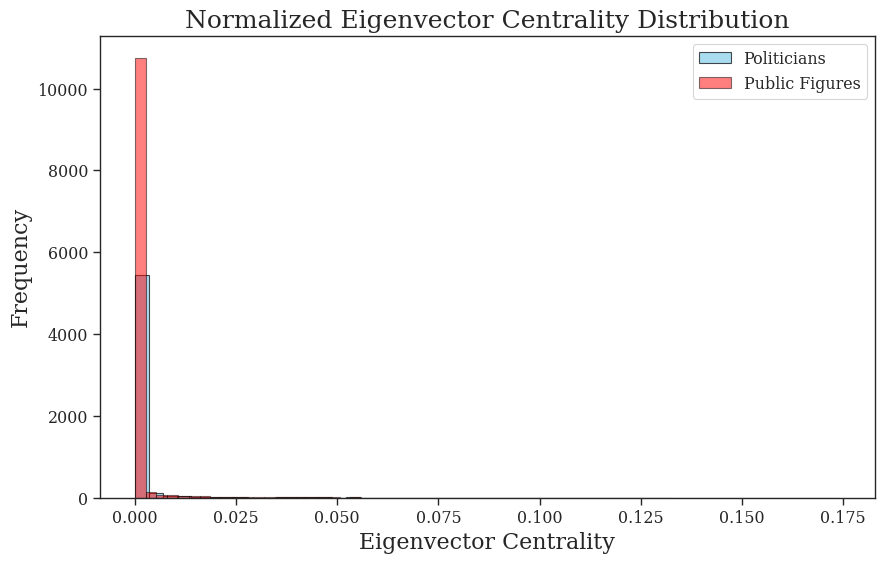

\begin{tabular}{lll}
\toprule
 & Politicians & Public Figures \\
\midrule
Max Node & Katarina Barley (0.1741) & 徐若瑄 Vivian Hsu (0.1330) \\
Min Node & Chris Sununu (0.0000) & Ismael Del Toro Castro (0.0000) \\
Average & 0.0027 & 0.0019 \\
\bottomrule
\end{tabular}



In [39]:
# Calculating Eigenvector Centrality
politician_eigenvector = nx.eigenvector_centrality(politician_graph)
public_figures_eigenvector = nx.eigenvector_centrality(public_figures_graph)

plot_histogram(politician_eigenvector, public_figures_eigenvector, "Eigenvector")

# Get degree stats for politicians and public figures
politician_stats = get_metric_stats(politician_eigenvector, politician_graph)
public_figures_stats = get_metric_stats(public_figures_eigenvector, public_figures_graph)

# Create a DataFrame to display in a table format
comparison_df = pd.DataFrame({
    "": ["Max Node", "Min Node", "Average"],
    "Politicians": [
        f"{politician_stats['max_node']} ({politician_stats['max_value']:.4f})",
        f"{politician_stats['min_node']} ({politician_stats['min_value']:.4f})",
        f"{politician_stats['avg_value']:.4f}"
    ],
    "Public Figures": [
        f"{public_figures_stats['max_node']} ({public_figures_stats['max_value']:.4f})",
        f"{public_figures_stats['min_node']} ({public_figures_stats['min_value']:.4f})",
        f"{public_figures_stats['avg_value']:.4f}"
    ]
})

# Print the LaTeX code for the table
print(comparison_df.to_latex(index=False))

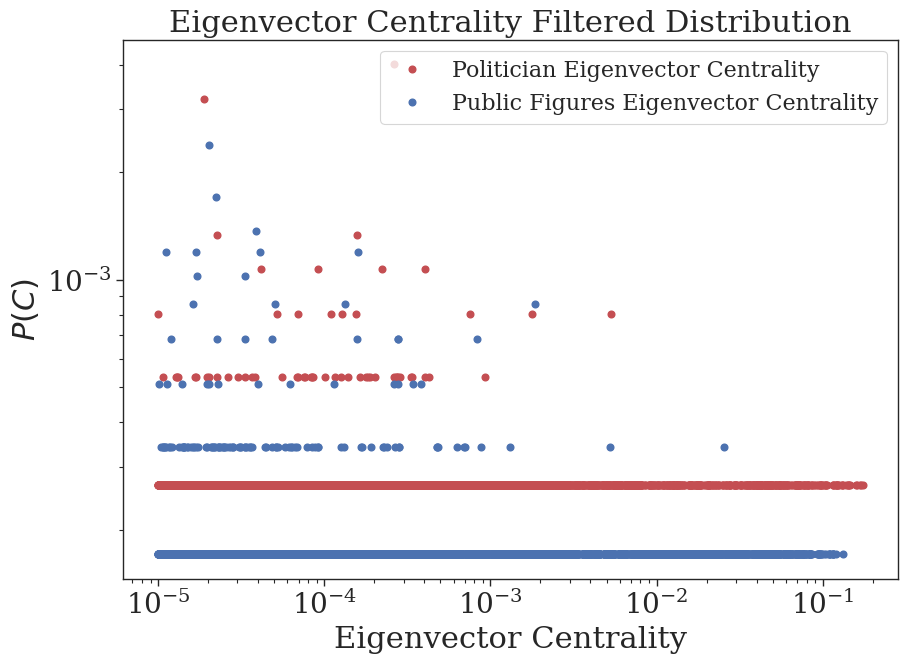

In [44]:
eigen_centrality_politicians = nx.eigenvector_centrality(politician_graph)
eigen_centrality_public = nx.eigenvector_centrality(public_figures_graph)

threshold = 1e-5  # Set the threshold for filtering
eigen_centrality_values_politicians = [v for v in eigen_centrality_politicians.values() if v > threshold]
eigen_centrality_values_public = [v for v in eigen_centrality_public.values() if v > threshold]

# Ensure there are entries above the threshold before proceeding
if eigen_centrality_values_politicians and eigen_centrality_values_public:
    # Create a frequency distribution of eigenvector centrality values
    eigen_centrality_distribution_politicians = Counter(eigen_centrality_values_politicians)
    eigen_centrality_distribution_public = Counter(eigen_centrality_values_public)

    # Sort the distributions and prepare data for plotting
    sorted_eigen_politicians = sorted(eigen_centrality_distribution_politicians.keys())
    sorted_counts_politicians = [eigen_centrality_distribution_politicians[d] for d in sorted_eigen_politicians]
    x_eigen_politician = sorted_eigen_politicians
    y_eigen_politician = [eigen_centrality_distribution_politicians[d] / sum(sorted_counts_politicians) for d in sorted_eigen_politicians]

    sorted_eigen_public = sorted(eigen_centrality_distribution_public.keys())
    sorted_counts_public = [eigen_centrality_distribution_public[d] for d in sorted_eigen_public]
    x_eigen_public = sorted_eigen_public
    y_eigen_public = [eigen_centrality_distribution_public[d] / sum(sorted_counts_public) for d in sorted_eigen_public]

    # Create the figure and axes objects
    fig, ax = plt.subplots(figsize=(10, 7))

    # Plot the normalized frequency of eigenvector centrality
    ax.plot(x_eigen_politician, y_eigen_politician, 'ro', label='Politician Eigenvector Centrality')
    ax.plot(x_eigen_public, y_eigen_public, 'bo', label='Public Figures Eigenvector Centrality')

    # Set both axes to log scale
    ax.set_xscale('log')
    ax.set_yscale('log')

    # Customize the plot
    ax.legend(fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_xlabel('Eigenvector Centrality', fontsize=22)
    ax.set_ylabel('$P(C)$', fontsize=22)
    ax.set_title('Eigenvector Centrality Filtered Distribution', fontsize=22)

    plt.show()
else:
    print("No eigenvector centrality values are above the threshold for one or both graphs.")

## Centrality Correlation Analysis

In [ ]:
degree_centrality = politician_degree
betweenness_centrality = politician_betweenness
closeness_centrality = politician_closeness
eigenvector_centrality = politician_eigenvector

In [70]:
degree_centrality = public_figures_degree
betweenness_centrality = public_figures_betweenness
closeness_centrality = public_figures_closeness
eigenvector_centrality = public_figures_eigenvector

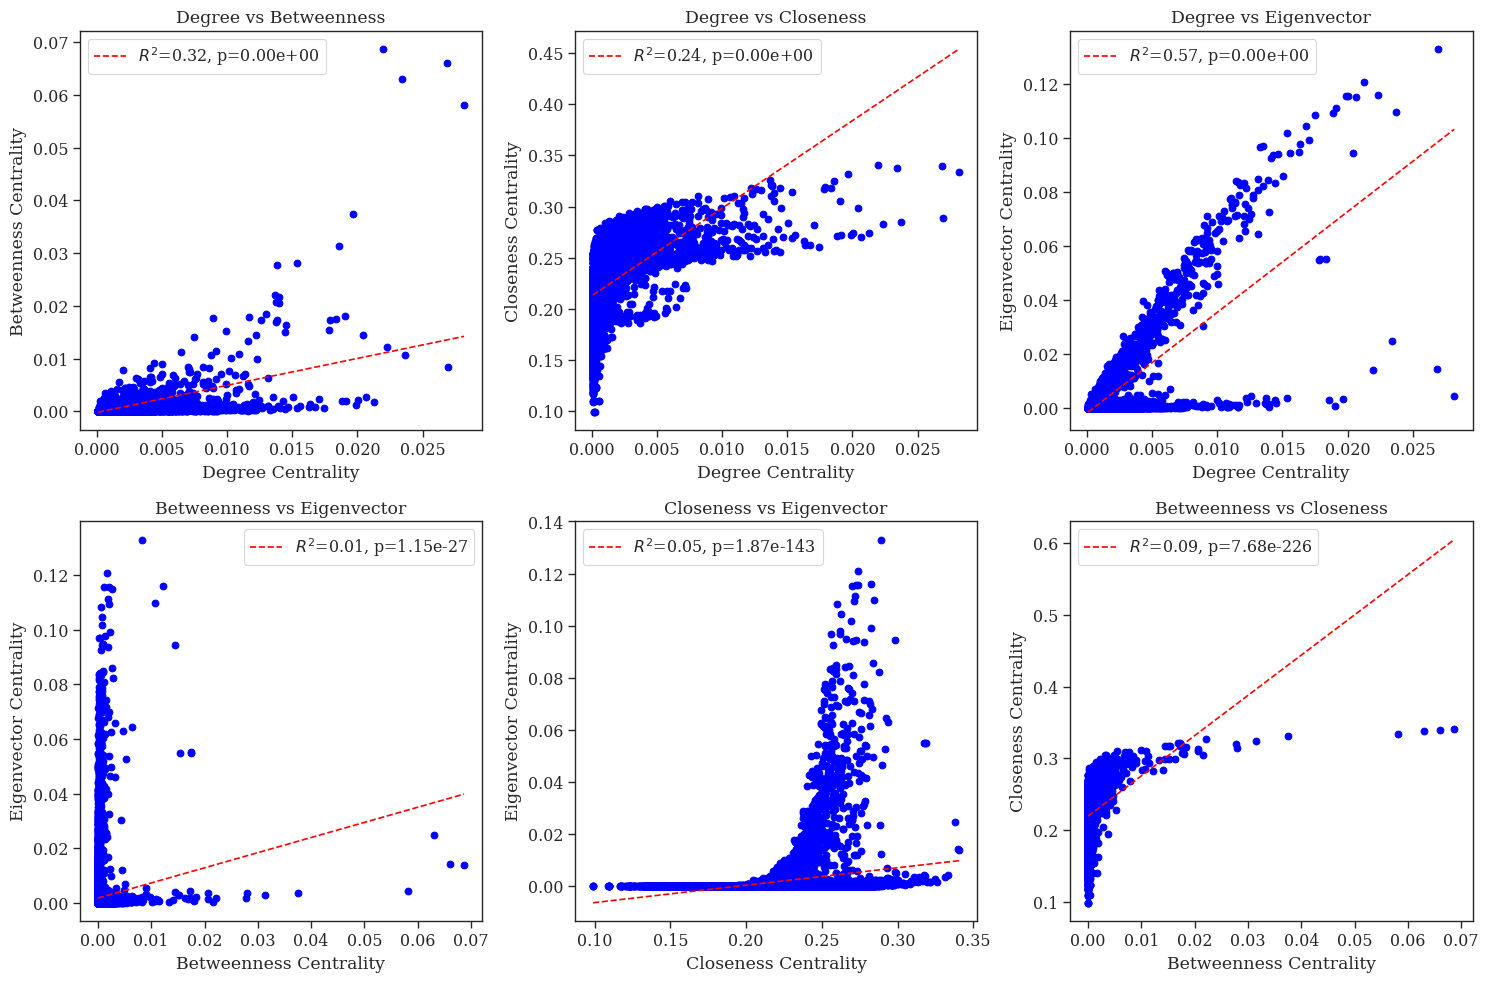

In [71]:
# Prepare to plot
fig, axs = plt.subplots(2, 3, figsize=(15, 10))  # 2 rows, 3 columns

# List of centralities for easier iteration
centralities = [
    (degree_centrality, betweenness_centrality, 'Degree', 'Betweenness'),
    (degree_centrality, closeness_centrality, 'Degree', 'Closeness'),
    (degree_centrality, eigenvector_centrality, 'Degree', 'Eigenvector'),
    (betweenness_centrality, eigenvector_centrality, 'Betweenness', 'Eigenvector'),
    (closeness_centrality, eigenvector_centrality, 'Closeness', 'Eigenvector'),
    (betweenness_centrality, closeness_centrality, 'Betweenness', 'Closeness')
]

# Titles for subplots
titles = [
    'Degree vs Betweenness',
    'Degree vs Closeness',
    'Degree vs Eigenvector',
    'Betweenness vs Eigenvector',
    'Closeness vs Eigenvector',
    'Betweenness vs Closeness'
]

# Scatterplots with regression
for idx, ((x_centrality, y_centrality, xlabel, ylabel), title) in enumerate(zip(centralities, titles)):
    # Get values and compute regression
    x_values = np.array(list(x_centrality.values()))
    y_values = np.array(list(y_centrality.values()))
    regression = linregress(x_values, y_values)

    # Compute regression line
    x_fit = np.linspace(x_values.min(), x_values.max(), 100)
    y_fit = regression.slope * x_fit + regression.intercept

    # Plot
    ax = axs[idx // 3, idx % 3]
    ax.scatter(x_values, y_values, color='blue')
    ax.plot(x_fit, y_fit, color='red', linestyle='--', label=f'$R^2$={regression.rvalue**2:.2f}, p={regression.pvalue:.2e}')
    ax.set_title(title)
    ax.set_xlabel(xlabel + ' Centrality')
    ax.set_ylabel(ylabel + ' Centrality')
    ax.legend()

# Adjust layout
plt.tight_layout()
plt.show()

## COMPONENT ANALYSIS

In [5]:
def analyze_graph(graph):
    num_components = nx.number_connected_components(graph)
    avg_local_clustering = nx.average_clustering(graph)
    global_clustering = nx.transitivity(graph)

    # Calculating the average shortest path length of the largest connected component
    if nx.is_connected(graph):
        avg_shortest_path_length = nx.average_shortest_path_length(graph)
    else:
        largest_cc = max(nx.connected_components(graph), key=len)
        subgraph = graph.subgraph(largest_cc)
        avg_shortest_path_length = nx.average_shortest_path_length(subgraph)

    return num_components, avg_local_clustering, global_clustering, avg_shortest_path_length

# Analyze both graphs
politician_metrics = analyze_graph(politician_graph)
public_figures_metrics = analyze_graph(public_figures_graph)

# Prepare data for LaTeX table
data = {
    "Network": ["Politician Network", "Public Figures Network"],
    "Number of Components": [politician_metrics[0], public_figures_metrics[0]],
    "Average Local Clustering Coefficient": [politician_metrics[1], public_figures_metrics[1]],
    "Global Clustering Coefficient": [politician_metrics[2], public_figures_metrics[2]],
    "Average Shortest Path Length": [politician_metrics[3], public_figures_metrics[3]]
}

# Generate LaTeX table code
def generate_latex_table(data):
    headers = data.keys()
    rows = zip(*data.values())
    latex_table = "\\begin{table}[H]\n\\centering\n"
    latex_table += "\\begin{tabular}{" + "l" + "c" * (len(headers) - 1) + "}\n"
    latex_table += "\\toprule\n"
    latex_table += " & ".join(headers) + " \\\\\n"
    latex_table += "\\midrule\n"
    for row in rows:
        latex_table += " & ".join(map(str, row)) + " \\\\\n"
    latex_table += "\\bottomrule\n"
    latex_table += "\\end{tabular}\n"
    latex_table += "\\caption{Network Analysis Metrics Comparison}\n"
    latex_table += "\\label{tab:network_analysis}\n"
    latex_table += "\\end{table}"
    return latex_table

# Print LaTeX table
latex_table = generate_latex_table(data)
print(latex_table)

\begin{table}[H]
\centering
\begin{tabular}{lcccc}
\toprule
Network & Number of Components & Average Local Clustering Coefficient & Global Clustering Coefficient & Average Shortest Path Length \\
\midrule
Politician Network & 1 & 0.38509612579327435 & 0.3010737363311825 & 4.664106961904097 \\
Public Figures Network & 1 & 0.1793472511782467 & 0.1665644876656779 & 4.622979301417417 \\
\bottomrule
\end{tabular}
\caption{Network Analysis Metrics Comparison}
\label{tab:network_analysis}
\end{table}


In [6]:
# computation is too expensive, stopped it after 25 hours


def compute_small_world_metrics(graph):
    # Check if graph is connected for small-world computations
    if nx.is_connected(graph):
        sigma = nx.sigma(graph)
        omega = nx.omega(graph)
    else:
        sigma = float('nan')  # Not a number, because small-worldness metrics need the graph to be connected
        omega = float('nan')
    return sigma, omega

# Compute small-world metrics for both graphs
sigma_politician, omega_politician = compute_small_world_metrics(politician_graph)
sigma_public_figures, omega_public_figures = compute_small_world_metrics(public_figures_graph)

# Data for the LaTeX table, focusing on small-worldness metrics only
small_world_data = {
    "Network": ["Politician Network", "Public Figures Network"],
    "$\sigma$": [sigma_politician, sigma_public_figures],
    "$\omega$": [omega_politician, omega_public_figures]
}

# Generate LaTeX table code for small-worldness metrics
def generate_latex_table_small_world(data):
    headers = data.keys()
    rows = zip(*data.values())
    latex_table = "\\begin{table}[H]\n\\centering\n"
    latex_table += "\\begin{tabular}{" + "l" + "c" * (len(headers) - 1) + "}\n"
    latex_table += "\\toprule\n"
    latex_table += " & ".join(headers) + " \\\\\n"
    latex_table += "\\midrule\n"
    for row in rows:
        latex_table += " & ".join(map(str, row)) + " \\\\\n"
    latex_table += "\\bottomrule\n"
    latex_table += "\\end{tabular}\n"
    latex_table += "\\caption{Comparison of Small-World Metrics}\n"
    latex_table += "\\label{tab:small_world_metrics}\n"
    latex_table += "\\end{table}"
    return latex_table

# Print LaTeX table
latex_table_small_world = generate_latex_table_small_world(small_world_data)
print(latex_table_small_world)

<>:18: SyntaxWarning: invalid escape sequence '\s'
<>:19: SyntaxWarning: invalid escape sequence '\o'
<>:18: SyntaxWarning: invalid escape sequence '\s'
<>:19: SyntaxWarning: invalid escape sequence '\o'
C:\Users\User\AppData\Local\Temp\ipykernel_12576\1101023016.py:18: SyntaxWarning: invalid escape sequence '\s'
  "$\sigma$": [sigma_politician, sigma_public_figures],
C:\Users\User\AppData\Local\Temp\ipykernel_12576\1101023016.py:19: SyntaxWarning: invalid escape sequence '\o'
  "$\omega$": [omega_politician, omega_public_figures]
C:\Users\User\AppData\Local\Temp\ipykernel_12576\1101023016.py:18: SyntaxWarning: invalid escape sequence '\s'
  "$\sigma$": [sigma_politician, sigma_public_figures],
C:\Users\User\AppData\Local\Temp\ipykernel_12576\1101023016.py:19: SyntaxWarning: invalid escape sequence '\o'
  "$\omega$": [omega_politician, omega_public_figures]


KeyboardInterrupt: 

## COMMUNITY DETECTION

In [9]:
import community as community_louvain


# Function to perform community detection and compute modularity
def analyze_communities(graph):
    # Perform community detection using the Louvain method
    partition = community_louvain.best_partition(graph)
    # Calculate modularity
    modularity = community_louvain.modularity(partition, graph)
    # Count number of unique communities
    num_communities = len(set(partition.values()))

    return modularity, num_communities

# Analyze both graphs
politician_modularity, politician_communities = analyze_communities(politician_graph)
public_figures_modularity, public_figures_communities = analyze_communities(public_figures_graph)

# Prepare data for LaTeX table
data = {
    "Network": ["Politician Network", "Public Figures Network"],
    "Modularity": [f"{politician_modularity:.4f}", f"{public_figures_modularity:.4f}"],
    "Number of Communities": [politician_communities, public_figures_communities]
}

# Generate LaTeX table code
def generate_latex_table(data):
    headers = data.keys()
    rows = zip(*data.values())
    latex_table = "\\begin{table}[H]\n\\centering\n"
    latex_table += "\\begin{tabular}{" + "l" + "c" * (len(headers) - 1) + "}\n"
    latex_table += "\\toprule\n"
    latex_table += " & ".join(headers) + " \\\\\n"
    latex_table += "\\midrule\n"
    for row in rows:
        latex_table += " & ".join(map(str, row)) + " \\\\\n"
    latex_table += "\\bottomrule\n"
    latex_table += "\\end{tabular}\n"
    latex_table += "\\caption{Community Analysis Results}\n"
    latex_table += "\\label{tab:community_analysis}\n"
    latex_table += "\\end{table}"
    return latex_table

# Print LaTeX table
latex_table = generate_latex_table(data)
print(latex_table)

\begin{table}[H]
\centering
\begin{tabular}{lcc}
\toprule
Network & Modularity & Number of Communities \\
\midrule
Politician Network & 0.8671 & 30 \\
Public Figures Network & 0.6836 & 31 \\
\bottomrule
\end{tabular}
\caption{Community Analysis Results}
\label{tab:community_analysis}
\end{table}
36
176
